# Preliminary sizing of a rotor blade

As previously mentioned we will use the work of Adkins and Liebeck to perform both optimisation and off design analysis. Let us start with the rotor blade optimisation.

The method has been implemented in Python in the package called `tuduam`, i.e TU Delft Urban Air Mobility. Hence, when creating the input we have to keep in mind the [documentation]() (<span style="color: red;"> TODO: insert missing link) </span> on what the functions expect. Feel free to roam around the documentatin to see what other functionalities are offered by the package. Keep in mind however that the package is under active development.

The design is initiated with the specified conditions of power (or thrust), hub and tip radius, rotational rate, freestream velocity, number of blades, and a finite number of stations at which blade geometry is to be determined. Let us define this in the next block

## Defining the conditions

Most of the code below does not need explaining, however as previusly mentioned we must take into account the [API documentation]() (<span style="color: red;"> TODO: insert missing link).</span> Here it says that the blade parameter must be defined in the `Propeller` data structure. Furthermore, BEM analysis requires airfoil polar at a large range of reynolds numbers. `tuduam` relies on the user to input this data in the form of a path to a directory which contains all the polars. These files should be in the common format outputted by [xfoil](https://web.mit.edu/drela/Public/web/xfoil/). A tutorial on how to create this data has also been made [here]()(<span style="color: red;"> TODO: insert missing link to data creation notebook). </span>. Sample data for the NACA 4412, a common propeller, is readily available however in the `tuduam` repository. The NACA 4412 is shown in [Figure 1](#figure1)

<br>
<p align="center"  id="figure1" style="background-color: white;">
<img src="https://raw.githubusercontent.com/saullocastro/tuduam/076078cd60feddd2ee2d784fcd93ccbed26041c6/notebooks/static/naca4412-il.svg" width="400" /> 
 <br>
</p>
<p align="center">
<em>Figure 1: The NACA 4412 airfoil</em>
</p>
<br>

The conditions required for the optimisation are loaded into the Python kernel below. Carefully read the comments surrounding the code for more pointers. Note that the repository makes use of data structures in order to limit input size into functions, in this case we have to make use of the `Propeller` data structure.

In [12]:
import sys
import os
sys.path.insert(0, os.path.dirname(os.path.abspath('')))

import tuduam as tud
import rich
import tuduam.propulsion as prop

# Define parameters required according to API documentation
data_path = os.path.realpath(os.path.join(os.path.abspath('.'), '..', 'examples', 'data')) # Path to airfoil data
coord_path = os.path.realpath(os.path.join(os.path.abspath('.'), '..', 'examples', 'naca_4412.txt')) # Path to airfoil coordinates
n_stations = 25

# Define operatonal parameters
thrust_req = 300
v_cruise = 210/3.6
h_cruise = 1200
isa = tud.ISA(h_cruise) 
a_snd = isa.soundspeed() # Speed of sound
rho_cr = isa.density() # Air density
dyn_vis = isa.viscosity_dyn() # Dynamic viscosity

# Define the specified conditions for the propeller geometry in the data structure
prop_class = tud.Propeller(
                    n_blades=6, # Number of blades
                    r_prop=0.48, # propeller radius
                    rpm_cruise=1200, 
                    tc_ratio=0.12,  # Thickness to chord ratio of airfoil
                    xi_0=0.1 # nondimensional hub radius (r_hub/R)
                    ) 

rich.print(f"{a_snd=}  \n{rho_cr=}  \n{dyn_vis=}  \n{prop_class=}")



a_snd=335.62572904948746  
rho_cr=1.0899402822825992  
dyn_vis=1.7736932645281385e-05  
prop_class=Propeller(n_blades=6.0, r_prop=0.48, rpm_cruise=1200.0, xi_0=0.1, chord_arr=None, rad_arr=None, 
pitch_arr=None, tc_ratio=0.12)

# Running the optimisation

Having defined the conditions we now run the actual optimisation. In the code it will be as simple as calling a single line however there is much going on in the background. A general overview of procedure is described here however for a full description refer to the paper (download link available in the course in sources). 

The general procedure can be condensed to the following:

1. Select an initial estimate for $\zeta$, the displacement velocity ratio ($\zeta$ = 0 will work).
2. Determine the values for $F$, the Prandtl momentum loss factor, and $\phi$, the flow angle, at each blade station.
3. Determine the product $Wc$, the local velocity multiplied by the local chord. Additionally, compute the Reynolds number.
4. Determine $\epsilon$, the drag-to-lift ratio, and $\alpha$, the angle of attack, from airfoil section data.
5. If $\epsilon$ is to be minimized, change $C_l$, and repeat Steps 3 and 4 until this is accomplished at each station.
6. Determine $\alpha$ and $\alpha'$, the axial and rotational interference factor, respectively.
7. Compute the chord from Step 3, and the blade twist $\beta = \alpha + \phi$.
8. Determine the four derivatives in I and J, and numerically integrate these from the non-dimensional hub radius, $\xi_0$ to the non-dimensional radius $\xi$ = 1.
9. Determine $\zeta$ and $T_c$, the thrust coefficient.
10. If this new value for $\zeta$ is not sufficiently close to the old one (e.g., within 0.1\%), start over at step 2 using the new $\zeta$.
11. Determine propeller efficiency as $\eta = \frac{T}{P_c}$, and other features such as solidity.

Let us now run the optimisation and plot the resulting blade geometry. The plotting is performed using a class called `PlotBlade`, which has a method for both a 3D and 2D plot. Feel free to play with the parameters of the rotor by rerunning the above code box with new parameters. Note that the optimisation will crash however for infeasible designs.

{
    'chord_arr': array([0.05599376, 0.07139863, 0.08577855, 0.09902369, 0.11104297,
       0.12176176, 0.13112863, 0.13910638, 0.14552351, 0.15066436,
       0.15439824, 0.15673775, 0.15769999, 0.15730515, 0.15556807,
       0.15249916, 0.14809407, 0.1423272 , 0.13514545, 0.12644173,
       0.11620314, 0.1037258 , 0.08853714, 0.06912588, 0.04015294]),
    'pitch_arr': array([1.52933606, 1.5016736 , 1.47248448, 1.44530601, 1.41843694,
       1.39017304, 1.36404283, 1.33659008, 1.30784565, 1.28132738,
       1.25705883, 1.23331457, 1.2083657 , 1.18571591, 1.16188436,
       1.14036854, 1.11942714, 1.09731632, 1.07752587, 1.05656219,
       1.04140181, 1.02331164, 1.00402916, 0.98703598, 0.96883135]),
    'alpha_arr': array([0.05585054, 0.05759587, 0.05759587, 0.05934119, 0.06108652,
       0.06108652, 0.06283185, 0.06283185, 0.06108652, 0.06108652,
       0.06283185, 0.06457718, 0.06457718, 0.06632251, 0.06632251,
       0.06806784, 0.06981317, 0.06981317, 0.0715585 , 0.0715585 ,
       0.07679449, 0.07853982, 0.07853982, 0.08028515, 0.08028515]),
    'station_arr': array([0.05664, 0.07392, 0.0912 , 0.10848, 0.12576, 0.14304, 0.16032,
       0.1776 , 0.19488, 0.21216, 0.22944, 0.24672, 0.264  , 0.28128,
       0.29856, 0.31584, 0.33312, 0.3504 , 0.36768, 0.38496, 0.40224,
       0.41952, 0.4368 , 0.45408, 0.47136]),
    'drag_to_lift_arr': array([0.02329602, 0.02309855, 0.02290547, 0.02286218, 0.02295302,
       0.02276904, 0.0226838 , 0.02250705, 0.00812469, 0.00806317,
       0.00804892, 0.0080353 , 0.00797705, 0.007965  , 0.00790894,
       0.00790949, 0.00793248, 0.00787912, 0.00790291, 0.00785137,
       0.02159191, 0.02150867, 0.02137488, 0.02126508, 0.02113704]),
    'v_e': 87.49038368597466,
    'solidity': array([0.94403429, 0.92235755, 0.89816313, 0.87168752, 0.8431793 ,
       0.81287695, 0.78105426, 0.74795501, 0.71307837, 0.67813851,
       0.64260574, 0.60665339, 0.57042575, 0.53404206, 0.4975769 ,
       0.46107515, 0.42452996, 0.38787804, 0.35099652, 0.31365065,
       0.2758697 , 0.23610518, 0.19355939, 0.14537164, 0.08134597]),
    'cl': array([0.81661538, 0.82373077, 0.83084615, 0.83796154, 0.84507692,
       0.85219231, 0.85930769, 0.86642308, 0.87353846, 0.88065385,
       0.88776923, 0.89488462, 0.902     , 0.90911538, 0.91623077,
       0.92334615, 0.93046154, 0.93757692, 0.94469231, 0.95180769,
       0.95892308, 0.96603846, 0.97315385, 0.98026923, 0.98738462]),
    'cd': array([0.01902389, 0.01902699, 0.01903092, 0.01915763, 0.01939707,
       0.0194036 , 0.01949236, 0.01950063, 0.00709723, 0.00710086,
       0.00714558, 0.00719066, 0.0071953 , 0.0072411 , 0.00724641,
       0.0073032 , 0.00738087, 0.00738728, 0.00746582, 0.00747299,
       0.02070498, 0.02077821, 0.02080105, 0.02084551, 0.02087038]),
    'eff': 0.7680638314288806,
    'tc': 0.2235026163289662,
    'pc': 0.2909948459793626,
    'zeta': 0.49980988396753423
}

power required = 2.06887452884454 Kw

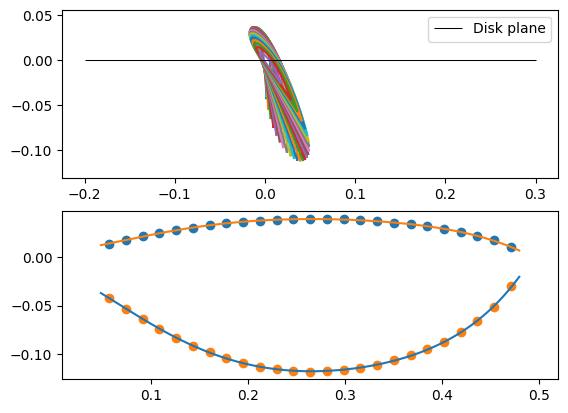

In [13]:
# Initiazlie BEM class
design = prop.BEM(data_path, prop_class, rho_cr, 
                  dyn_vis, v_cruise, n_stations, a_snd, T=thrust_req)

# Execute the BEM optimisation with initial estimate of 0
res_dict = design.optimise_blade(zeta_init=0)

# Print the resulting dictionary 
rich.print(res_dict)
rich.print(f'power required = {res_dict["pc"]*rho_cr*(prop_class.rpm_cruise/60)**3*32*prop_class.r_prop**5/1e3} Kw')

# Plot the resulting blade geometry 
plot = prop.PlotBlade(prop_class, coord_path)
plot.plot_blade() # Creates two 2D plots
plot.plot_3D_plotly() # Creates an interactive 3D plot

# Offdesign analysis

We now have an optimised blade which is stored in the `Propeller` data structure and in the output of the function, i.e `res_dict`. We can do a quick test in order to check this.  Run the following cell to see what the data structure now contains. As seen it now contains 3 extra arrays describing the propeller blade.

We would now like to test whether it can meet a certain off design condition. If you want to know more about  a specific step, please refer to the paper which is available on the course site. The general procedure for doing so is as follows:

1. Specify a freestream velocity, RPM and $\Delta \beta$
2. Make in initial estimate on the flow angle using $\phi = \frac{\lambda}{\xi}$ where $\xi$ is the nondimensional spanwise location and $\lambda= \frac{V_{inf}}{\omega*R} $
3. Since $\beta$ is known, compute $\alpha = \beta - \phi$ and the Reynolds number at each station.
4. The airfoil coefficients are then known from the airfoil section data.
5. The new estimate for $\phi$ can then be computed as in equation 1. Let a and $a`$ be the axial and rotational interference factor, r the local radius and V the freestream velocity. Note that a and $a`$  are clipped to -0.7 and 0.7 respectively. This is required for adequate convergence near the tip (Viterna and Janetzke (1981)). For more details please see Adkins and Liebeck (1984) on the course site.

$$
\begin{equation}
\tag{1}
\tan \phi = \frac{V(1 + a)}{\Omega r (1 -  a`)}
\end{equation}
$$
6. Steps 1 to 5 are then repeated until convergence is reached.
7. The thrust and torque per unit radius can then be found using:

$$
\begin{align}
\tag{2}
T` & = \frac{1}{2} \rho W^2 cB  C_y \\ 
\tag{3}
Q`/r & = \frac{1}{2} \rho W^2 cB  C_x \\
\end{align}
$$

8. Then finally the thrust and power coefficient are defined as folows. Where n is the rounds per second.

$$
\begin{align}
\tag{4}
C_T & = \frac{T}{\rho n^2 16 R^4} \\
\tag{5}
C_P & = \frac{P}{\rho n^3 32 R^5} \\
\end{align}
$$

Finally, this can then be integrated. In the source code this is done using a simple trapezoid integration, more specifically  the `scipy.integrate.trapezoid` function. 

# Hover example

Let's do an sample example of a vtol rising vertically to see how this would look like using the `tuduam` repository. The inflow from the freestream is now significantly reduced. The parameter that significantly changes is the freestream velocity, the only significant component left is the induced velocity caused by the rotor. Determining the value of the induced velocity is difficult, engineering judgement is used. [1] mentions an equation to estimate it however it is only reliable for higher flight speeds. Thus in our script we have assumed the freestream velocity to be 10.

Furthermore it is important to consider how we should change our pitch control of the rotor.  As seen in [Figure 2](#figure2), the resultant relative wind will lay nearly in parrallel to tip-path axis. Therefore if we would keep the same pitch as the one during cruise the blade will most surely stall. The implication in the code being an error that an angle of attack outside of the dataset has been encountered. 

<p align="center"  id="figure2" style="background-color: white;">
<img src="https://github.com/saullocastro/tuduam/blob/main/notebooks/static/hover_blade_cross_sectin.gif?raw=true" width="400" /> 
 <br>
</p>

Therefore we would like to lower our pitch angle. To increase the thrust for hover we would like to increase our RPM. However keep in mind that our rpm is limited by the onset of shock waves at the tip of the blade. Thus we have to compute the maximum rpm and limit the rpm to that value.  WE will now analyse the propeller at a singular offdesign conditions. Namely a freestream velocity of 10 m/s, a maximum mach number of 0.7 at the tip and a 39 degree decrease in pitch on the rotor blades. Read and run the code below for the results.


## Sources

[1] Castles, W. Jr., & De Leeuw, J. H. (1954). The normal component of the induced velocity in the vicinity of a lifting rotor and some examples of its application (Report No. 1184). Georgia Institute of Technology.



In [14]:
import numpy as np
from scipy.optimize import minimize

# Define constants required for analysis
mach_max = 0.7 # Point when shockwave occurs over the airfoil
isa = tud.ISA(0) # Assume sea level
rho = isa.density()
dyn_vis = isa.viscosity_dyn()
a_snd = isa.soundspeed()

# Operations conditions
vtip_max =  mach_max*a_snd
omega_max = vtip_max/prop_class.r_prop
rpm_hvr = omega_max/(2*np.pi)*60 # Vertical speed of the vtol
v_hvr = 10 # Vertical speed of the vtol plus additional 
delta_pitch = np.radians(-39)

rich.print(f"{rpm_hvr=}")

hover_cond = prop.OffDesignAnalysisBEM(data_path, prop_class, v_hvr, rpm_hvr, rho, dyn_vis, a_snd)
res = hover_cond.analyse_propeller(delta_pitch, abs_extrapolation=7)

power_req = res["power_coeff"]*rho*(rpm_hvr/60)**3*32*prop_class.r_prop**5/1e3

rich.print(res)
rich.print(f"The power required for a single rotor is {power_req} kW")

rpm_hvr=4738.517215834462

{
    'thrust': 4419.032502473501,
    'torque': 250.73183574196435,
    'eff': 0.3551784721041339,
    'thrust_coeff': 0.6809633682639923,
    'power_coeff': 0.25288010895744534,
    'AoA': array([0.1423678 , 0.23904863, 0.31567315, 0.35780088, 0.3832793 ,
       0.39591067, 0.40261618, 0.39008215, 0.38604095, 0.38045883,
       0.37423864, 0.36333966, 0.36745979, 0.34352246, 0.34106323,
       0.32180639, 0.31494238, 0.2993096 , 0.28451342, 0.26940751,
       0.26085072, 0.24988789, 0.23592288, 0.22123105, 0.20721302]),
    'lift_coeff': array([1.30557414, 1.4332331 , 1.18948776, 1.19193914, 1.19484236,
       1.19822076, 1.20210434, 1.48031609, 1.48987353, 1.5066467 ,
       1.52992904, 1.55843736, 1.5713342 , 1.61628175, 1.6520912 ,
       1.68914404, 1.72705699, 1.78770459, 1.81470819, 1.83479384,
       1.87820904, 1.91970041, 1.94726879, 1.93847994, 1.95414693]),
    'drag_coeff': array([0.02381066, 0.05729719, 0.14762968, 0.14793392, 0.14829425,
       0.14871355, 0.14919554, 0.16721165, 0.16787538, 0.16015633,
       0.15200172, 0.13986003, 0.02057486, 0.02371346, 0.02450081,
       0.09862643, 0.02944767, 0.07611041, 0.06442242, 0.07619482,
       0.06663979, 0.08174522, 0.0369091 , 0.11566614, 0.14686628])
}

The power required for a single rotor is 124.4172394879241 kW

# Finding the max thrust of a blade

 Let us now try a range of values for the both the change in pitch and rpm values to see if we can achieve better thrust values. We could opt to use `scipy.optimize` for this purpose however the analysis is prone to failure due to either to high AoA or a non-convergent solutions. This will complicate the optimization where we'll have to assign penalization when such an error occurs. Instead we'll use a  brute force method since the analysis is swift. We'll create a mesh where x will be the rpm and y the pitch. Then for each coordinate we'll compute the thrust and plot a surface. This is implemented below, the cell takes about 30 seconds to run, so some patience is required. Additionally besides the thrust, the efficiency and power are also be plotted.

Feel free to play with the parameters!

In [15]:
import plotly.graph_objects as go

n = 15 # Mesh size

pitch_arr  = np.linspace(-20, -50, n)
rpm_arr = np.linspace(2500,rpm_hvr, n)
X,Y = np.meshgrid(rpm_arr,pitch_arr)
Z_thrust = np.zeros(X.shape)
Z_eff = np.zeros(X.shape)
Z_power = np.zeros(X.shape)

for col, rpm in enumerate(rpm_arr):
    hover_cond = prop.OffDesignAnalysisBEM(data_path, prop_class, v_hvr, rpm, rho, dyn_vis, a_snd)

    for row, dpitch in enumerate(np.radians(pitch_arr)):
        try:
            res = hover_cond.analyse_propeller(dpitch, abs_extrapolation=7)
        except ValueError:
            print(f"pitch {np.radians(dpitch)} results in AoA outside of the dataset and the additional extrapolation range")
            continue
        except RuntimeError as error:
            print(error)
            continue

        power_req = res["power_coeff"]*rho*(rpm_hvr/60)**3*32*prop_class.r_prop**5/1e3

        Z_thrust[row,col] = res["thrust"]
        Z_eff[row,col] = res["eff"]*100
        Z_power[row,col] =  power_req


for type, data in zip(["thrust", "Efficiency", "Power"],[Z_thrust, Z_eff, Z_power]):
    # Create the figure
    fig = go.Figure(data=[go.Surface(z=data, x=X, y=Y)])
    fig.update_layout(
        scene=dict(
            xaxis_title='RPM',
            yaxis_title=r'$\Delta \beta$',
            zaxis_title=f'{type} [N]'))

    fig.update_layout(
        scene_camera=dict(
            eye=dict(x=1.8, y=1.8, z=1.8)))

    fig.update_layout(title=f'{type} plot {n} x {n} mesh ', autosize=True,
                    margin=dict(l=65, r=50, b=65, t=90))

    # Show the plot
    fig.show()


pitch -0.006092348395734171 results in AoA outside of the dataset and the additional extrapolation range
pitch -0.006745100009562833 results in AoA outside of the dataset and the additional extrapolation range
pitch -0.007397851623391494 results in AoA outside of the dataset and the additional extrapolation range
pitch -0.008050603237220157 results in AoA outside of the dataset and the additional extrapolation range
Convergence failed maximum amount of iterations was reached
Convergence failed maximum amount of iterations was reached
Convergence failed maximum amount of iterations was reached
Convergence failed maximum amount of iterations was reached
Convergence failed maximum amount of iterations was reached
Convergence failed maximum amount of iterations was reached
Convergence failed maximum amount of iterations was reached
Convergence failed maximum amount of iterations was reached
Convergence failed maximum amount of iterations was reached
pitch -0.006092348395734171 results in A

# Iteration of the rotor design.

So what happens if the maximum thrust we find is not sufficient? Remember when a thrust or power value was specified for which the rotor would be optimized? We can increase this value  to increase the maximum thrust value, this however does come a cost that the blade is less efficient at the cruise setting. With the updated geometry we can then perform the offdesign analysis again to find the newly acquired maximum thrust. This process is then repeated until the engineer is  sufficiently happy with the margin on the maximum thrust and the design thrust of the propeller.

The opportunity is given below to go through this process yourself with the code cell below where all of the relevant code has been appended. The mesh spacing has been increased to decrease computation time, however if nearing to your final design you can decrease the mesh spacing again. The design point is described in the first few lines of code. Sometimes the results are odd with the majority failing or having no solution at all. In this case it is advised to increase the radius of your propeller or change the amount of blades.

In [17]:
# Define operatonal parameters
thrust_req = 350
v_cruise = 210/3.6
h_cruise = 1200
isa = tud.ISA(h_cruise) 
a_snd = isa.soundspeed() # Speed of sound
rho_cr = isa.density() # Air density
dyn_vis = isa.viscosity_dyn() # Dynamic viscosity

# Define the specified conditions for the propeller geometry in the data structure
prop_class = tud.Propeller(
                    n_blades=6, # Number of blades
                    r_prop=0.5, # propeller radius
                    rpm_cruise=1200, 
                    tc_ratio=0.12,  # Thickness to chord ratio of airfoil
                    xi_0=0.1 # nondimensional hub radius (r_hub/R)
                    ) 

#---------------------------- Blade geometry optimization ---------------------------------
# Initiazlie BEM class
design = prop.BEM(data_path, prop_class, rho_cr, 
                  dyn_vis, v_cruise, n_stations, a_snd, T=thrust_req)

# Execute the BEM optimisation with initial estimate of 0
res_dict = design.optimise_blade(zeta_init=0)
plot.plot_3D_plotly() # Creates an interactive 3D plot

#------------------- Off design analysis ---------------------------------------------------------
n = 5 # Mesh size

pitch_arr  = np.linspace(-20, -50, n)
rpm_arr = np.linspace(2500,rpm_hvr, n)
X,Y = np.meshgrid(rpm_arr,pitch_arr)
Z_thrust = np.zeros(X.shape)
Z_eff = np.zeros(X.shape)
Z_power = np.zeros(X.shape)

for col, rpm in enumerate(rpm_arr):
    hover_cond = prop.OffDesignAnalysisBEM(data_path, prop_class, v_hvr, rpm, rho, dyn_vis, a_snd)

    for row, dpitch in enumerate(np.radians(pitch_arr)):
        try:
            res = hover_cond.analyse_propeller(dpitch, abs_extrapolation=7)
        except ValueError:
            print(f"pitch {np.radians(dpitch)} results in AoA outside of the dataset and the additional extrapolation range")
            continue
        except RuntimeError as error:
            print(error)
            continue

        power_req = res["power_coeff"]*rho*(rpm_hvr/60)**3*32*prop_class.r_prop**5/1e3

        Z_thrust[row,col] = res["thrust"]
        Z_eff[row,col] = res["eff"]*100
        Z_power[row,col] =  power_req


# Create the figure
fig = go.Figure(data=[go.Surface(z=Z_thrust, x=X, y=Y)])
fig.update_layout(
    scene=dict(
        xaxis_title='RPM',
        yaxis_title=r'$\Delta \beta$',
        zaxis_title=f'Thrust [N]'))

fig.update_layout(
    scene_camera=dict(
        eye=dict(x=1.8, y=1.8, z=1.8)))

fig.update_layout(title=f'{type} plot {n} x {n} mesh ', autosize=True,
                margin=dict(l=65, r=50, b=65, t=90))

# Show the plot
fig.show()


pitch -0.006092348395734171 results in AoA outside of the dataset and the additional extrapolation range
pitch -0.008376979044134486 results in AoA outside of the dataset and the additional extrapolation range
Convergence failed maximum amount of iterations was reached
Convergence failed maximum amount of iterations was reached
Convergence failed maximum amount of iterations was reached
pitch -0.006092348395734171 results in AoA outside of the dataset and the additional extrapolation range
pitch -0.008376979044134486 results in AoA outside of the dataset and the additional extrapolation range
Convergence failed maximum amount of iterations was reached
Convergence failed maximum amount of iterations was reached
pitch -0.006092348395734171 results in AoA outside of the dataset and the additional extrapolation range
pitch -0.008376979044134486 results in AoA outside of the dataset and the additional extrapolation range
Convergence failed maximum amount of iterations was reached
pitch -0.0